In [2]:
import pandas as pd
import pypsa

In [28]:
n= pypsa.Network('../networks/base_LC_27-supply.nc')

INFO:pypsa.io:Imported network base_LC_27-supply.nc has buses, lines


In [46]:
n= pypsa.Network('../networks/sector_csir-aggressive_redz_E_LC_27-supply.nc')

INFO:pypsa.io:Imported network sector_csir-aggressive_redz_E_LC_27-supply.nc has buses, carriers, generators, lines, loads, storage_units


<AxesSubplot:xlabel='snapshot'>

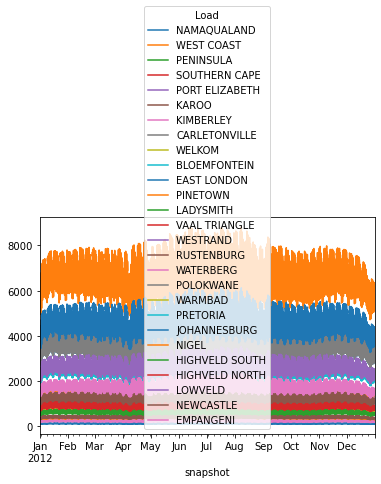

In [48]:
n.loads_t.p_set.plot()

In [41]:
def apply_time_segmentation(n, segments, solver_name="cbc"):
    logger.info(f"Aggregating time series to {segments} segments.")
    try:
        import tsam.timeseriesaggregation as tsam
    except:
        raise ModuleNotFoundError("Optional dependency 'tsam' not found."
                                "Install via 'pip install tsam'")

    p_max_pu_norm = n.generators_t.p_max_pu.max()
    p_max_pu = n.generators_t.p_max_pu / p_max_pu_norm

    load_norm = n.loads_t.p_set.max()
    load = n.loads_t.p_set / load_norm
    
    inflow_norm = n.storage_units_t.inflow.max()
    inflow = n.storage_units_t.inflow / inflow_norm

    raw = pd.concat([p_max_pu, load, inflow], axis=1, sort=False)

    agg = tsam.TimeSeriesAggregation(raw, hoursPerPeriod=len(raw),
                                    noTypicalPeriods=1, noSegments=int(segments),
                                    segmentation=True, solver=solver_name)

    segmented = agg.createTypicalPeriods()

    weightings = segmented.index.get_level_values("Segment Duration")
    offsets = np.insert(np.cumsum(weightings[:-1]), 0, 0)
    snapshots = [n.snapshots[0] + pd.Timedelta(f"{offset}h") for offset in offsets]

    n.set_snapshots(pd.DatetimeIndex(snapshots, name='name'))
    n.snapshot_weightings = pd.Series(weightings, index=snapshots, name="weightings", dtype="float64")
    
    segmented.index = snapshots
    n.generators_t.p_max_pu = segmented[n.generators_t.p_max_pu.columns] * p_max_pu_norm
    n.loads_t.p_set = segmented[n.loads_t.p_set.columns] * load_norm
    n.storage_units_t.inflow = segmented[n.storage_units_t.inflow.columns] * inflow_norm

    return n